# Detectron2 - Inspect Training Data

Inspect and visualize data loading and pre-processing code.

In [ ]:
import os
import sys

import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from importlib import import_module

import yaml
import logging
import logging.config
from easydict import EasyDict as edict

AI_CODE_BASE_PATH = '/codehub'
BASE_PATH_CONFIG = os.path.join(AI_CODE_BASE_PATH,'config')
APP_ROOT_DIR = os.path.join(AI_CODE_BASE_PATH,'apps')

if APP_ROOT_DIR not in sys.path:
  sys.path.insert(0, APP_ROOT_DIR)

import _cfg_
from annon.dataset.Annon import ANNON
import apputil

from _log_ import logcfg
log = logging.getLogger(__name__)
logging.config.dictConfig(logcfg)

appcfg = _cfg_.load_appcfg(BASE_PATH_CONFIG)
appcfg = edict(appcfg)

from detectron2.structures import BoxMode
from detectron2.utils import visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# %matplotlib inline 

In [3]:
# MODELINFO_FILEPATH = '/codehub/cfg/model/release/vidteq-ods-7-mask_rcnn.yml'
HOST = "10.4.71.69"
AI_ANNON_DATA_HOME_LOCAL ="/aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119"

cmd = "train"
dbname = "PXL-291119_180404"
exp_id = "train-422d30b0-f518-4203-9c4d-b36bd8796c62"
subset = "val"

eval_on = subset

In [28]:

def load_hmdcoco(cfg, datacfg, img_ids, bbox_mode):
    class_ids = datacfg.class_ids if 'class_ids' in datacfg and datacfg['class_ids'] else []
    class_ids = annon.getCatIds(catIds=class_ids) ## cat_ids
    classinfo = annon.loadCats(class_ids) ## cats
    # print("class_ids: {}".format(class_ids))
    # print("classinfo: {}".format(classinfo))

    # print(img_ids)
    imgs = annon.loadImgs(img_ids)
    anns = [annon.imgToAnns[img_id] for img_id in img_ids]
    # print(anns)

    ## => quick hack for running detectron2 with gaze data
    ## TODO: Convert to COCO -> if done in pre-processing, this step not required here

    imgs_anns = list(zip(imgs, anns))
    dataset_dicts = []
    extra_annotation_keys=None

    ## TODO: iscrowd is available in attributes as something like group
    ann_keys = ["iscrowd", "bbox", "keypoints", "category_id", "lbl_id"] + (extra_annotation_keys or [])
    num_instances_without_valid_segmentation = 0
    id_map = {v: i for i, v in enumerate(class_ids)}

    for (img_dict, anno_dict_list) in imgs_anns:
        image_path = apputil.get_abs_path(cfg, img_dict, 'AI_ANNON_DATA_HOME_LOCAL') ##image_root
        filepath = os.path.join(image_path, img_dict['filename'])
        record = {}
        record["file_name"] = filepath
        record["height"] = img_dict["height"]
        record["width"] = img_dict["width"]
        image_id = record["image_id"] = img_dict["img_id"] ## coco: id

        objs = []
        for anno in anno_dict_list:
            assert anno["img_id"] == image_id ## image_id
            obj = {key: anno[key] for key in ann_keys if key in anno}
            ##TODO: convert bbbox to coco format
            _bbox = obj['bbox']

            ##TODO: verify what is BoxMode.XYWH_ABS
            coco_frmt_bbox = [_bbox['xmin'], _bbox['ymin'], _bbox['width'], _bbox['height'] ]
            #print("coco_frmt_bbox: {}".format(coco_frmt_bbox))
            obj['bbox'] = coco_frmt_bbox
            ## TODO: get polygon from shape_attributes and conver to coco format
            #segm = anno.get("segmentation", None)
            segm = None
            if segm:  # either list[list[float]] or dict(RLE)
                if not isinstance(segm, dict):
                    # filter out invalid polygons (< 3 points)
                    segm = [poly for poly in segm if len(poly) % 2 == 0 and len(poly) >= 6]
                    if len(segm) == 0:
                        num_instances_without_valid_segmentation += 1
                        continue  # ignore this instance
                    obj["segmentation"] = segm

            obj["bbox_mode"] = bbox_mode
            if id_map:
                obj["category_id"] = id_map[obj["lbl_id"]] ## category_id
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

## Configurations

Run one of the code blocks below to import and load the configurations to use.

In [4]:
appcfg['APP']['DBCFG']['PXLCFG']['host'] = HOST
appcfg['PATHS']['AI_ANNON_DATA_HOME_LOCAL'] = AI_ANNON_DATA_HOME_LOCAL

# log.debug(appcfg)
# log.info(appcfg['APP']['DBCFG']['PXLCFG'])
# log.info(appcfg['PATHS']['AI_ANNON_DATA_HOME_LOCAL'])

In [5]:
## datacfg and dbcfg
_cfg_.load_datacfg(cmd, appcfg, dbname, exp_id, eval_on)
datacfg = apputil.get_datacfg(appcfg)
dbcfg = apputil.get_dbcfg(appcfg)

# log.info("datacfg: {}".format(datacfg))
# log.info("dbcfg: {}".format(dbcfg))

2019-12-28 09:56:28,820:[DEBUG]:[__main__._cfg_]:[_cfg_.py:65 -         load_datacfg() ]: ----------------------------->
2019-12-28 09:56:28,822:[DEBUG]:[__main__._cfg_]:[_cfg_.py:66 -         load_datacfg() ]: cmd, appcfg, dbname, exp_id, eval_on:  train, {'PATHS': {'AI_ANNON_DATA_HOME': '/data/samba/Bangalore/prod/Bangalore_Maze_Exported_Data/ANNOTATIONS', 'AI_ANNON_DATA_HOME_LOCAL': '/aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119', 'AI_ANNON_DB': '/aimldl-dat/data-gaze/AIML_Database', 'AI_ANNON_HOME': '/codehub/apps/annon', 'AI_APP': '/codehub/apps', 'AI_CFG': '/codehub/cfg', 'AI_CONFIG': '/codehub/config', 'AI_DATA': '/aimldl-dat', 'AI_DETECTRON_ROOT': '/codehub/external/detectron2', 'AI_DOC': '/aimldl-doc', 'AI_GOOGLE_APPLICATION_CREDENTIALS': '/codehub/auth/', 'AI_HOME': '/codehub', 'AI_HOME_EXT': '/codehub/external', 'AI_KBANK': '/aimldl-kbank', 'AI_LANENET_ROOT': '/codehub/external/lanenet-lane-detection', 'AI_LOGS': '/aimldl-dat/logs', 'AI_MNT': '/aimldl-mnt', 'AI_MODEL_

## Dataset

In [6]:
## archcfg, cmdcfg

_cfg_.load_archcfg(cmd, appcfg, dbname, exp_id, eval_on)
archcfg = apputil.get_archcfg(appcfg)
log.debug("archcfg: {}".format(archcfg))
cmdcfg = archcfg


2019-12-28 09:56:30,707:[DEBUG]:[__main__._cfg_]:[_cfg_.py:119 -         load_archcfg() ]: ----------------------------->
2019-12-28 09:56:30,710:[DEBUG]:[__main__._cfg_]:[_cfg_.py:150 -         load_archcfg() ]: DBCFG: {'ANNONCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'annon_v5', 'host': 'localhost', 'name': 'hmd', 'password': '', 'port': 27017, 'return_hmd': None, 'username': ''}, 'CBIRCFG': {'dbname': 'eka', 'host': 'localhost', 'password': '', 'port': 27017, 'username': ''}, 'OASISCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'oasis', 'host': 'localhost', 'name': 'hmd', 'password': '', 'port': 27017, 'return_hmd': None, 'username': ''}, 'PXLCFG': {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'PXL-291119_180404', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'return_

In [7]:
dataset, num_classes, num_images, class_names, total_stats, total_verify = apputil.get_dataset_instance(appcfg, dbcfg, datacfg, subset)
# colors = viz.random_colors(len(class_names))

log.debug("class_names: {}".format(class_names))
log.debug("len(class_names): {}".format(len(class_names)))
# log.debug("len(colors), colors: {},{}".format(len(colors), colors))
log.debug("num_classes: {}".format(num_classes))
log.debug("num_images: {}".format(num_images))

name = dataset.name
datacfg.name = name
datacfg.classes = class_names
datacfg.num_classes = num_classes

cmdcfg.name = name
cmdcfg.config.NAME = name
cmdcfg.config.NUM_CLASSES = num_classes

# dnnmod = apputil.get_module(cmdcfg.dnnarch)
# get_dnncfg = apputil.get_module_fn(dnnmod, "get_dnncfg")
# ## dnncfg
# dnncfg = get_dnncfg(cmdcfg.config)

2019-12-28 09:56:31,259:[INFO]:[__main__.apputil]:[apputil.py:199 - get_dataset_instance() ]: -------------------------------->
2019-12-28 09:56:31,261:[DEBUG]:[__main__.apputil]:[apputil.py:200 - get_dataset_instance() ]: datacfg: {'created_on': '2019-11-29 18:04:13 +05:30', 'allowed_file_type': ['.txt', '.csv', '.yml', '.json'], 'allowed_image_type': ['.pdf', '.png', '.jpg', '.jpeg', '.gif'], 'allowed_video_type': ['.mp4'], 'annon_type': 'hmd', 'config': {'DETECTION_MIN_CONFIDENCE': 0.9, 'GPU_COUNT': 1, 'IMAGES_PER_GPU': 1, 'IMAGE_MAX_DIM': 1280, 'IMAGE_MIN_DIM': 720, 'STEPS_PER_EPOCH': 1000}, 'creator': 'AIE1', 'dataclass': 'AnnonDataset', 'dbname': 'PXL-291119_180404', 'device': '/gpu:0', 'dnnarch': 'mask_rcnn', 'filename': '281119_123250-AIE1-21-mask_rcnn.yml', 'filepath': '/aimldl-cfg/arch/281119_123250-AIE1-21-mask_rcnn.yml', 'framework_type': 'keras', 'load_weights': {'by_name': True, 'exclude': ['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask']}, 'log_dir': 'm

2019-12-28 09:56:31,863:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:121 -    load_data_from_db() ]: classinfo: [{'lbl_id': 'signage', 'name': 'signage', 'source': 'hmd'}, {'lbl_id': 'traffic_light', 'name': 'traffic_light', 'source': 'hmd'}, {'lbl_id': 'traffic_sign', 'name': 'traffic_sign', 'source': 'hmd'}]
2019-12-28 09:56:31,866:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:130 -    load_data_from_db() ]: len(release): 0
2019-12-28 09:56:31,868:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:168 -          createIndex() ]: -------------------------------->
2019-12-28 09:56:31,878:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:196 -          createIndex() ]: index created!
2019-12-28 09:56:31,879:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:55 -             __init__() ]: Done (t=0.23s)
2019-12-28 09:56:31,880:[DEBUG]:[__main__.utils.AnnonDataset]:[AnnonDataset.py:370 -             load_hmd() ]: subset, class_ids: val, ['signage', 'traffic_light', 'traffic_sign']
2019-12-28

In [8]:
datamod = import_module('utils.'+datacfg.dataclass)
datamodcls = getattr(datamod, datacfg.dataclass)
name = datacfg.name
dataset = datamodcls(name)

total_img, total_annotation, total_classes, annon = dataset.load_data(appcfg, dbcfg, datacfg, subset)

2019-12-28 09:56:32,696:[INFO]:[__main__.Base]:[Base.py:38 -             __init__() ]: -------------------------------->
2019-12-28 09:56:32,699:[DEBUG]:[__main__.Base]:[Base.py:58 -             __init__() ]: classinfo: [{'source': '', 'id': 0, 'name': 'BG'}]
2019-12-28 09:56:32,710:[INFO]:[__main__.utils.AnnonDataset]:[AnnonDataset.py:97 -            load_data() ]: --------------------------------> val
2019-12-28 09:56:32,712:[INFO]:[__main__.utils.AnnonDataset]:[AnnonDataset.py:104 -            load_data() ]: load_data:-----> hmd
2019-12-28 09:56:32,713:[INFO]:[__main__.utils.AnnonDataset]:[AnnonDataset.py:109 -            load_data() ]: load_data::fname: load_hmd
2019-12-28 09:56:32,715:[INFO]:[__main__.utils.AnnonDataset]:[AnnonDataset.py:354 -             load_hmd() ]: -------------------------------->
2019-12-28 09:56:32,717:[DEBUG]:[__main__.utils.AnnonDataset]:[AnnonDataset.py:355 -             load_hmd() ]: datacfg: {'created_on': '2019-11-29 18:04:13 +05:30', 'allowed_file_ty

In [10]:
annon = ANNON(dbcfg, datacfg, subset=subset)

2019-12-28 09:56:53,892:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:40 -             __init__() ]: -------------------------------->
2019-12-28 09:56:53,894:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:59 -            load_data() ]: -------------------------------->
2019-12-28 09:56:53,895:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:76 -    load_data_from_db() ]: -------------------------------->
2019-12-28 09:56:53,896:[DEBUG]:[__main__.annon.dataset.Annon]:[Annon.py:82 -    load_data_from_db() ]: dbcfg: {'annon_type': 'hmd', 'class_ids': None, 'data_read_threshold': -1, 'dataclass': 'AnnonDataset', 'dbname': 'PXL-291119_180404', 'host': '10.4.71.69', 'name': 'hmd', 'password': '', 'port': 27017, 'return_hmd': None, 'username': ''}
2019-12-28 09:56:54,025:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:121 -    load_data_from_db() ]: classinfo: [{'lbl_id': 'signage', 'name': 'signage', 'source': 'hmd'}, {'lbl_id': 'traffic_light', 'name': 'traffic_light', 'source': 'hmd'}, 

In [25]:
dataset_name = datacfg.name
meta = MetadataCatalog.get(dataset_name)

meta.thing_classes = class_ids
meta.thing_dataset_id_to_contiguous_id = id_map

In [30]:
# img_ids = sorted(list(annon.imgs.keys()))
# imgs = annon.loadImgs(img_ids)

# # print(img_ids)
# anns = [annon.imgToAnns[img_id] for img_id in img_ids]
# # print(anns)

# ## => quick hack for running detectron2 with gaze data
# ## TODO: Convert to COCO -> if done in pre-processing, this step not required here

# imgs_anns = list(zip(imgs, anns))
# dataset_dicts = []
# extra_annotation_keys=None

# ## TODO: iscrowd is available in attributes as something like group
# ann_keys = ["iscrowd", "bbox", "keypoints", "category_id", "lbl_id"] + (extra_annotation_keys or [])
# num_instances_without_valid_segmentation = 0

# for (img_dict, anno_dict_list) in imgs_anns:
#     image_path = apputil.get_abs_path(appcfg, img_dict, 'AI_ANNON_DATA_HOME_LOCAL') ##image_root
#     filepath = os.path.join(image_path, img_dict['filename'])
#     record = {}
#     record["file_name"] = filepath
#     record["height"] = img_dict["height"]
#     record["width"] = img_dict["width"]
#     image_id = record["image_id"] = img_dict["img_id"] ## coco: id
    
#     objs = []
#     for anno in anno_dict_list:
#         assert anno["img_id"] == image_id ## image_id
#         obj = {key: anno[key] for key in ann_keys if key in anno}
# #         print("obj: {}".format(obj))
#         ##TODO: convert bbbox to coco format
#         _bbox = obj['bbox']
        
#         ##TODO: verify what is BoxMode.XYWH_ABS
#         coco_frmt_bbox = [_bbox['xmin'], _bbox['ymin'], _bbox['width'], _bbox['height'] ]
#         #print("coco_frmt_bbox: {}".format(coco_frmt_bbox))
#         obj['bbox'] = coco_frmt_bbox
#         ## TODO: get polygon from shape_attributes and conver to coco format
#         #segm = anno.get("segmentation", None)
#         segm = None
#         if segm:  # either list[list[float]] or dict(RLE)
#             if not isinstance(segm, dict):
#                 # filter out invalid polygons (< 3 points)
#                 segm = [poly for poly in segm if len(poly) % 2 == 0 and len(poly) >= 6]
#                 if len(segm) == 0:
#                     num_instances_without_valid_segmentation += 1
#                     continue  # ignore this instance
#                 obj["segmentation"] = segm

#         obj["bbox_mode"] = BoxMode.XYWH_ABS
#         if id_map:
#             obj["category_id"] = id_map[obj["lbl_id"]] ## category_id
#         objs.append(obj)
# #         break
    
#     record["annotations"] = objs
#     dataset_dicts.append(record)
# #     break

# # print("len(dataset_dicts): {}".format(len(dataset_dicts)))
# dataset_dicts[0]

{'file_name': '/aimldl-dat/data-gaze/AIML_Annotation/ods_job_230119/images/images-p1-230119_AT4/241118_113644_16717_zed_l_311.jpg',
 'height': 1080,
 'width': 1920,
 'image_id': 'img-002902c5-07fe-42a3-95fd-c084a5be5589',
 'annotations': [{'bbox': [0, 431, 21, 34],
   'lbl_id': 'traffic_sign',
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 2}]}

In [31]:
dataset_dicts = load_hmdcoco(appcfg, datacfg, img_ids, BoxMode.XYWH_ABS)

2019-12-28 10:38:30,568:[INFO]:[__main__.annon.dataset.Annon]:[Annon.py:365 -             loadCats() ]: -------------------------------->


In [18]:
DatasetCatalog.register(dataset_name, lambda dataset_dicts: dataset_dicts)

In [19]:
metadata = MetadataCatalog.get(dataset_name)
print("metadata: {}".format(metadata))

metadata: Metadata(name='hmd', thing_classes=['signage', 'traffic_light', 'traffic_sign'], thing_dataset_id_to_contiguous_id={'signage': 0, 'traffic_light': 1, 'traffic_sign': 2})


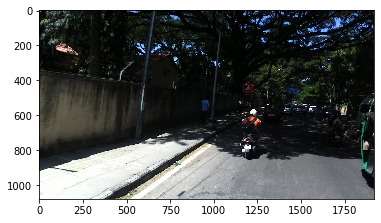

In [24]:
N = 1
for d in random.sample(dataset_dicts, N):
#     print(d)
    img = cv2.imread(d["file_name"])
#     viz = visualizer.Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    viz = visualizer.Visualizer(img, metadata=metadata, scale=1)
    vis = viz.draw_dataset_dict(d)
    # vis.save("/aimldl-dat/temp/det02.jpg")
    # cv2.imwrite("/aimldl-dat/temp/det01.jpg", vis.get_image()[:, :, ::-1])
    plt.imshow(vis.get_image()[:, :, ::-1])
#     cv2.imshow('', vis.get_image()[:, :, ::-1])